# Optimal Portfolio Theory and Asset Pricing

This notebook is an introduction to the basics portfolio construction. I start by a brief theoretical review the `Modern Portfolio Theory (MPT)`. After extending the theory, I show two empirical applications of this theory. Then, I review the `Capital Asset Pricing Model (CAPM)` as a basic asset pricing model, and two of its frequently used extensions 3- and 5-factor `Fama-French` models. I will end this notebook by estimating these models using real world date. 
The modern portfolio theory is a practical method for selecting investments in order to maximize their overall returns within an acceptable level of risk.

## Table of Contents

[1. Modern Portfolio Theory](#1) 

[2. Application (1): Industry Indices](#2) 

- [Data Exploration](#2.1) 
- [Efficient Frontier Analysis](#2.2)
    * [A Two-Asset Case](#2.2.1)
    * [Multi-Asset Case](#2.2.2)
- [Optimal Portfolios:](#2.3)
     * [Maximum Sharpe Ratio Portfolio(MSRP)](#2.3.1) 
     * [Minimum Variance Portfolio (MVP) ](#2.3.2)


[3. Application (2): Stock Indices](#3) 

- [Data Preprocessing](#3.1)
    * [Graphs](#3.1.1)
    * [Descrpitive and Financial Statistics](#3.1.2) 
    * [Factorability Tests](#3.1.3)
- [Efficient Frontier Analysis](#3.2)
- [Diversification in Practice ](#3.3)

[4. Empirical Asset Pricing Models](#4) 
- [Capital Asset Pricing Model](#4.1)
- [3-Factor Fama-French Model](#4.2)
- [5-Factor Fama-French Model](#4.3)



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import risk_mod as rm
import Portfolio_mod as pm
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick

from IPython.display import Image
from scipy.optimize import minimize
from statsmodels.iolib.summary2 import summary_col
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

import warnings
warnings.filterwarnings('ignore') #to suppress warning messages

# %load_ext autoreload
# %autoreload 2

## 1. Modern Portfolio Theory <a id="1"></a>

The modern portfolio theory (MPT), or mean-variance analysis, is a mathematical framework that maximizes the expected return of a portfolio for a given level of risk (or, alternatively minimize the risk for a given target return). This theory essentially formalizes the concept of `diversification` in investing by providing a coherent basis for comparing the contribution of each asset to the aggregate risk of a portfolio. Harry Markowitz (1952) first introduced this theory, for which he was later awarded a Nobel Prize in Economics. 

To better understand this model, let's start from the empirical fact that including more assets in a portfolio reduces the average risk. For example, if you were to randomly choose one individual stock from the S&P 500, its average standard deviation would be approximately 50 percent. The key observation is that dding more stocks reduces this standard deviation to less than 20 percent.


![alt](p1.PNG) 



This is the power of diversification, which is rooted in correlation between assets. Consider two stocks with expected returns $r_1$ and $r_2$, and standard deviations $\sigma_1$ and $\sigma_2$. Also, assume the the correlation between these stocks is given by $\rho$. If we construct a portfolio with corresponding weights of $w_1$ and $w_2$, then the expected return of the portfolio is given by 

$$
r_p = w_1 r_1 + w_2 r_2
$$

while its volatility is

$$
\sigma_p^2 = w_1^2 \sigma_1^2 + w_2^2 \sigma_2^2 + 2 w_1w_2\sigma_1 \sigma_2 \rho
$$

As long as the stocks are `imperfectly correlated` ($-1<\rho<1$):

$$
\sigma_p < w_1 \sigma_1 + w_2 \sigma_2.
$$


This results in the definition of a an `efficient frontier` where our return, given any level of risk is maximized. 
![alt](p2.PNG) 

In addition to the efficient frontier, which is colored in green, this analysis leads to the introduction of the minimum variance portfolio, which has the smallest varaince among all the portfolio that can be constructed. Since I want to keep this review brief, I jump to the optimization problem that defines the problem of an investor, which is to minimze risk given a target return rate $\bar{r}$:

$$ 
\begin{align} 
\min\limits_{w>0} \hspace{3mm} &\frac{1}{2}w^T \Sigma w \\
\text{subject to} \hspace{25mm}&\\
w^T R & = \bar{r} \\
w^T \mathbb{\large{1}}&= 1 \\
\end{align}
$$

where

* $w^T = [w_1, w_2, \ldots, w_n]$ is the vector of weights
* $R = [r_1, r_2, \ldots, r_n]$ is (expected) stock returns
* $ \Sigma$ is the variance-covariance matrix
* $\mathbb{\large{1}}$ is a vector of ones

Similarly, we can defint an optimization problem where the objective is to maximize the `Sharpe Ratio`, which is defined as

$$
S_p = \frac{r_p - r_f}{\sigma_p}
$$

In general, once a risk-free asset is introduced, the space of all potential portfolios expands. This is simply because any combination of the risk-free asset and any of the previous feasible portfolios would now be also feasible. Logically, we should only be interested in portfolios that combine the risk-free asset and another portfolio on the efficient frontier. Each of these combinations are on straight lines that run through the risk-free asset. However, not all of them are equally desirable. Among them, the one that has the highest slope is the best one. The `tangency portfolio` or the `Maximum Sharpe Ratio (MSR)` portfolio is the one that is both on this line (with highest slop) and on the efficient frontier. Such a protfolio is the solution to the following problem:


$$ 
\begin{align} 
\max\limits_{w>0} \hspace{3mm} &SR_p = \frac{w^T r - r_f}{\sqrt{w^T \Sigma w}}  \\
\text{subject to} \hspace{25mm}&\\
& w^T  \mathbb{\large{1}}= 1 \\
\end{align}
$$

Note that we can re-write the objective function as:

$$ SR_p = \frac{w^T r - r_f}{\sqrt{w^T \Sigma w}} = \frac{\Sigma_{i} w_i \mu_i - r_f}{\sqrt{\Sigma_{i}\Sigma_{j} w_i w_j \sigma_i \sigma_j \rho_{ij}}}$$

In the next two sections, I will use this theoretical framework to analyze real-world data.

Finally, the `Minimum Variance Portfolio (MVP)` solves:

$$ 
\begin{align} 
\min\limits_{w>0} \hspace{3mm} & \sigma_p \\
\text{subject to} \hspace{25mm}&\\
w^T  \mathbb{\large{1}} =& 1 \\
\end{align}
$$




## 2.  Application: Industry Indices <a id="2"></a>

I start the empirical sections of this notebook by analyzing the historical monthly returns of the US Stock market obtained from [this](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) webpage. I work with the 30 industry classification. This dataset starts from `1926-07` and runs through `2023-06`.

The only changes I make to make the data more readable are:
1) dividing all returns by 100 as they are stored in percentages
2) force the index column to be a `datetime` object and set its period
3) clean-up the coulmn names as there are extra spaces

In [2]:
ind = pd.read_csv("30_Industry_Return.csv", header = 0, index_col=0)/100
ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')

In [3]:
ind.shape

(1164, 30)

In [3]:
ind.columns

Index(['Food ', 'Beer ', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth ',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin  ', 'Other'],
      dtype='object')

In [4]:
# Cleaning: column names
ind.columns = ind.columns.str.strip()

In [38]:
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0191,-0.2379,0.0007,0.0187,-0.0002,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0797,...,0.0217,0.0202,0.0439,-0.0238,0.0485,0.0539,-0.0075,-0.0013,0.0447,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0230,...,0.0241,0.0225,0.0019,-0.0554,0.0007,-0.0787,0.0025,-0.0056,-0.0161,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0261,-0.1538,-0.0220,-0.0411,-0.0551,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0310,...,0.0163,0.0377,0.0364,0.0384,0.0161,0.0467,0.0652,0.0433,0.0234,0.0400


### Data Exploration <a id="2.1"></a>


In [150]:
print()
print("                                Table of Summary Stats for Industry Indices")
print("===============================================================================================================")

rm.summary_stats(ind.iloc[:,:])


                                Table of Summary Stats for Industry Indices


,Annualized Return,Ann. Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
Food,10.677,16.327,0.043,9.488,6.115,10.268,0.107,-72.246
Beer,12.077,24.549,1.757,25.324,3.319,14.236,0.121,-88.574
Smoke,12.182,20.187,-0.009,6.012,8.110,12.227,0.122,-59.875
Games,9.118,30.877,0.610,12.430,10.229,19.927,0.091,-95.628
Books,8.030,24.957,0.468,9.143,9.062,15.757,0.080,-91.579
Hshld,9.463,19.964,0.360,15.499,6.497,12.460,0.095,-88.710
Clths,9.294,21.511,0.243,7.031,8.335,12.902,0.093,-76.321
Hlth,11.667,19.119,0.086,9.559,7.133,11.443,0.117,-74.686
Chems,10.567,21.948,0.261,8.954,8.138,13.126,0.106,-85.957
Txtls,7.891,27.109,0.770,11.944,8.720,16.597,0.079,-87.452


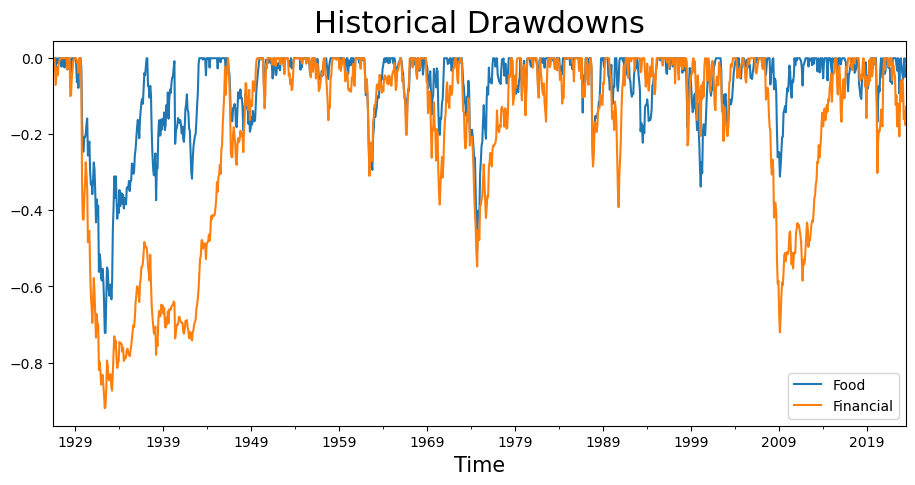

In [74]:
rm.drawdown(ind["Food"])["Drawdown"].plot.line(figsize = (11, 5), label = "Food")
rm.drawdown(ind["Fin"])["Drawdown"].plot(label = "Financial")
# rm.drawdown(ind["Hlth"])["Drawdown"].plot(label = "Health")

plt.title ("Historical Drawdowns", size = 22)
plt.xlabel("Time", size = 15)

plt.legend()

In [88]:
print()
print("        Top 10 Most Historically Volatile Indices")
print("========================================================")

rm.var_historic(ind).sort_values(ascending = False)[:10]


        Top 10 Most Historically Volatile Indices


Coal     0.143980
Games    0.122970
Steel    0.119080
Carry    0.106375
Books    0.106270
Autos    0.105310
ElcEq    0.103925
Mines    0.103025
Txtls    0.101740
Cnstr    0.099285
dtype: float64

In [17]:
print()
print("       Top 10 Least Historically Volatile Indices")
print("========================================================")

rm.var_historic(ind).sort_values()[:10]


       Top 10 Least Historically Volatile Indices


Food     0.066825
Telcm    0.070425
Hlth     0.071070
Util     0.073705
Chems    0.080085
Paper    0.081700
Hshld    0.082025
Smoke    0.082310
Rtail    0.082650
Beer     0.088940
dtype: float64

<Axes: title={'center': 'Industry Sharpe Ratios 1926-2023'}>

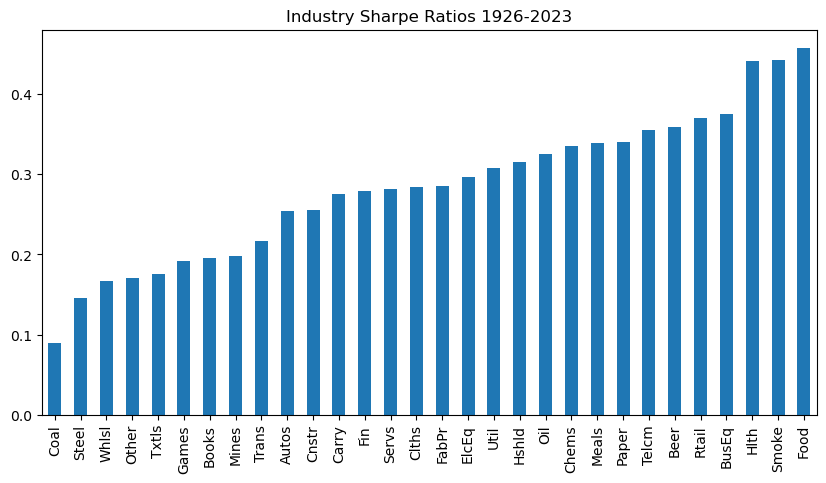

In [91]:
rm.sharpe_ratio(ind, 0.03, 12).sort_values().plot.bar(figsize=(10,5), title = "Industry Sharpe Ratios 1926-2023")

<Axes: title={'center': 'Industry Sharpe Ratios After the Great Recession'}>

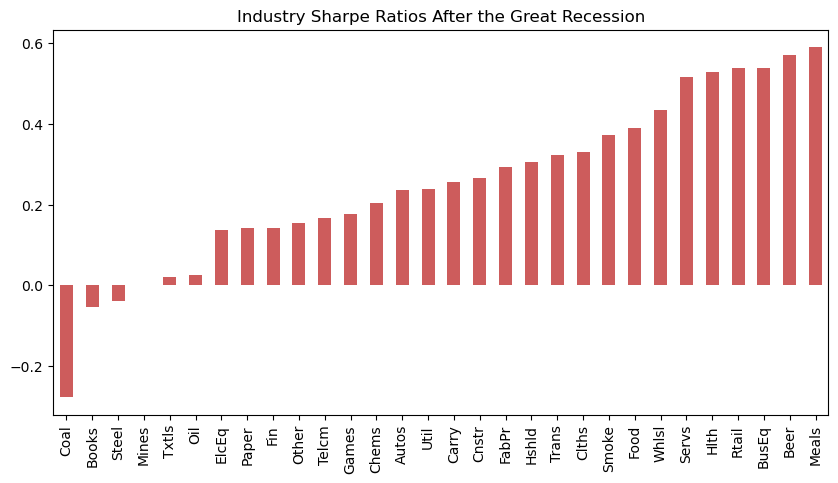

In [100]:
rm.sharpe_ratio(ind["2008":], 0.03, 12).sort_values().plot.bar(figsize=(10,5),
                                  title='Industry Sharpe Ratios After the Great Recession', color = "indianred")

###  Efficient Frontier Analysis <a id="2.2"></a>

Generating the efficient frontier requires a set of **expected returns** and a **covariance matrix**. I estiamte these based on the historical date. This may not be the best approach but, for now, I am naively assuming historical estimates will hold in the future. A better approach may be using a robust **factor model**, which will be introduced later. 



In [18]:
# vector of expected returns
exp_ret = rm.annualize_rets(ind[:], 12)

# covariance matrix
cov_mat = ind[:].cov()
cov_mat.shape

(30, 30)

[]

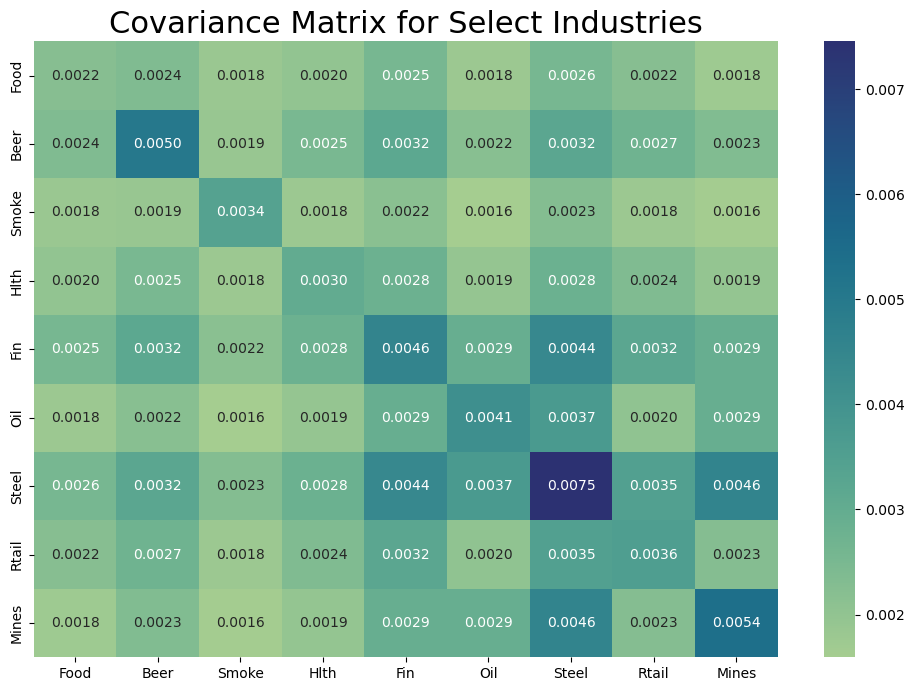

In [19]:
sel = ["Food", "Beer", "Smoke", "Hlth", "Fin", "Oil", "Steel", "Rtail", "Mines"]

plt.figure(figsize=(12, 8))
sns.heatmap(cov_mat.loc[sel,sel],
            annot = True,
              fmt = ".4f",
             cmap = 'crest')
plt.title("Covariance Matrix for Select Industries", size = 22)
plt.plot()

[]

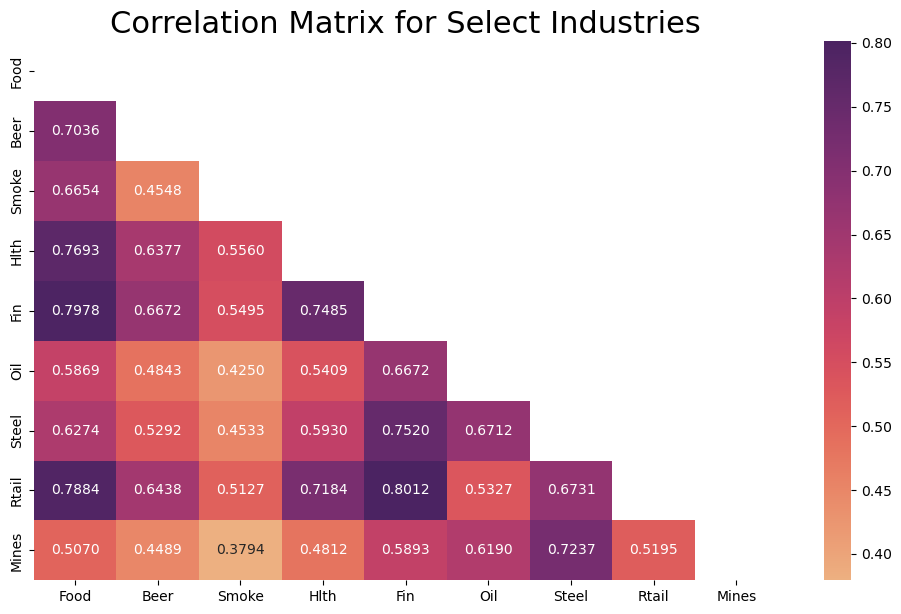

In [20]:
# sel     = ["Food", "Beer", "Smoke", "Hlth", "Fin", "Oil", "Steel", "Rtail", "Mines"]
cor_mat = ind[sel].corr() 

# Getting the Upper Triangle of the co-relation matrix
umat = np.triu(cor_mat)

plt.figure(figsize=(12, 7))
sns.heatmap(cor_mat,
            annot = True,
              fmt = ".4f",
             cmap = 'flare',
             mask = umat)
plt.title("Correlation Matrix for Select Industries", size = 22)
plt.plot()



### A Two-Asset Case<a id="2.2.1"></a>

I start by considering only two industries: `Steel` and `Autos`. This is obviously an arbitrary choice, and its sole purpose is to simplify our minimzation problem for demonstration. 

In a two-asset case, we only need to solve for the weight of one asset, `w`, in the portfolio as the weight of the other asset by definition is `1-w`. Therefore, instead of solving for an optimal weight, I am going to construct a `linear space` for the weight of the first asset (w). Then, I create a sequence of potential protfolios with weights `[w, 1-w]`. For each portfolio, I compute the annualized risk and return of that portfolio. Finally, I plot the obtained forntier.  


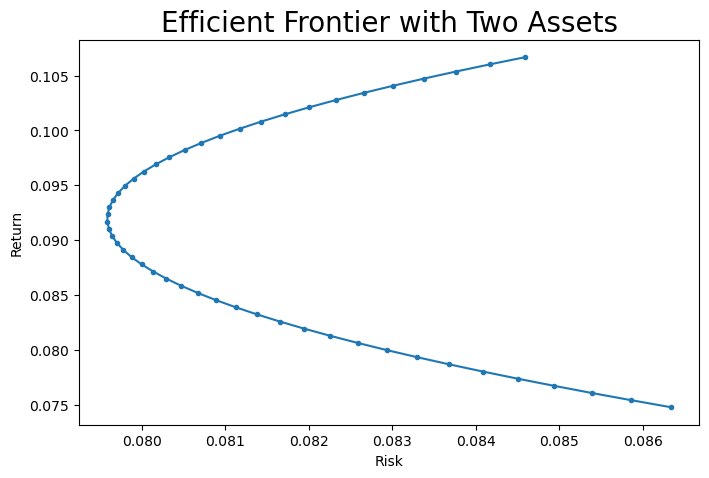

In [21]:
# List of assets
sel = ["Steel", "Autos"]

# number of points in the grid for weights
n_points = 50    

# dataframe of frontier points
frontier = pd.DataFrame(columns = ["Return", "Risk"], index = range(n_points))

# grid for weights
weights  = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]

# compute exp. return and volatility
for i,w in zip(range(n_points), weights):
    frontier.loc[i, "Return"] = w.T @ exp_ret[sel] 
    frontier.loc[i, "Risk"]   = (w.T @ cov_mat.loc[sel, sel] @ w)**0.5 


frontier.plot.line(x = "Risk", y = "Return", style = ".-", figsize=(8,5))
plt.title("Efficient Frontier with Two Assets", size = 20)
plt.ylabel("Return")
plt.legend().set_visible(False)


### Multi-Asset Case<a id="2.2.2"></a>

If there are more than two assets, then we need to solve an optimization problem. The way I do it here is by creating a `grid for returns`. Then, for each return, I solve for the optimal weights that `minimize volatility` of the portfolio. 


In [5]:
#  function to compute the volatility of a portfolio (objective function)
def vol_p(w, cov):
    """
    Inputs:
        w: vector of weights
        cov: covariance matrix
        
    Output:
        scalar, which is the volatility of this portfolio        
    """
    return (w.T @ cov @ w)**0.5




# function to compute min volatility portfolio for a target return
def min_vol(target, er, cov):
    """
    Inputs:
        target: a scalar target return
        er: expected returns
        cov: covariance matrix
        
    Output:
        optimal weights that minimize volatility given the target return
    """
    
    n      = er.shape[0]         # number of assets
    guess  = np.repeat(1/n, n)   # an equally weighted portfolio of assets as the initial guess
    bounds = ((0.0, 1.0),) * n   # For all assets, 0 <= w_i <= 1.0
    
    # equality constraint 1: sum of all weights = 1
    weights_sum = {'type': 'eq',
                   'fun' : lambda weights: np.sum(weights) - 1
    }
    
    # equality constraint 2: target return is achieved 
    targ_ret = {'type': 'eq',
              'args': (er,),
              'fun' : lambda weights, er: target - weights.T@er
    }
    
    opt_vol = minimize(vol_p,
                       guess,
                       args        = (cov,),
                       method      = 'SLSQP',
                       options     = {'disp': False},
                       constraints = (weights_sum, targ_ret),
                       bounds      = bounds
                      )
    return opt_vol

In [23]:
# List of assets
sel = ["Steel", "Autos", "Fin", "Games", "Books", "BusEq"]

# number of points in the grid for returns
n_points = 75    

# dataframe of frontier points
frontier = pd.DataFrame(columns = ["Return", "Risk"], index = range(n_points))

# grid for returns
ret_grid  = np.linspace(exp_ret[sel].min(), exp_ret[sel].max(), n_points)

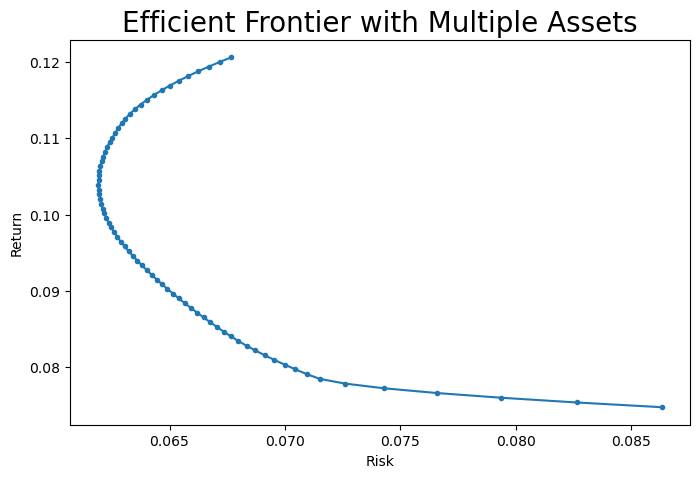

In [24]:
for i, r in zip(range(n_points), ret_grid):
    
    solution                  = min_vol(r, exp_ret[sel], cov_mat.loc[sel, sel])
    frontier.loc[i, "Return"] = solution.x.T @ exp_ret[sel] 
    frontier.loc[i, "Risk"]   = solution.fun


frontier.plot.line(x = "Risk", y = "Return", style = ".-", figsize=(8,5))
plt.title("Efficient Frontier with Multiple Assets", size = 20)
plt.ylabel("Return")
plt.legend().set_visible(False)

plt.show()

### Optimal Portfolios: Maximum Sharpe Ratio Portfolio (MSRP) <a id="2.3"></a> <a id="2.3.1"></a>
The objective here is to find a specific point on the efficient frontier where the Sharpe Ratio, given a risk free rate, is maximized. Such a portfolio is called `Maximum Sharpe Ratio (MSR)` or `Tangency` Portfolio, as it sits on the line that runs through the risk-free rate and is tangent to the efficient frontier. 

**Note:** For this exercise, 
* I assume `rf = 0.03`.
* I consider all the industries.
* I only consider data from 2000 to 2010. 

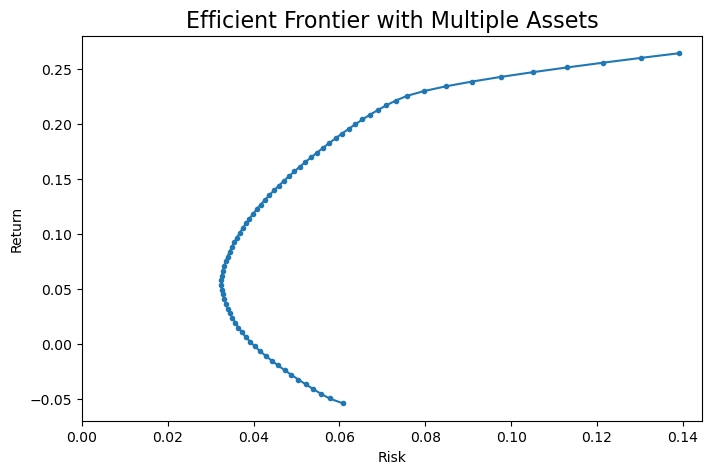

In [32]:
# vector of expected returns
exp_ret = rm.annualize_rets(ind.loc["2000":"2010", :], 12)

# covariance matrix
cov_mat = ind.loc["2000":"2010", :].cov()

sel = ind.columns

# number of points in the grid for returns
n_points = 75    

# dataframe of frontier points
frontier = pd.DataFrame(columns = ["Return", "Risk"], index = range(n_points))

# grid for returns
ret_grid  = np.linspace(exp_ret.min(), exp_ret.max(), n_points)

for i, r in zip(range(n_points), ret_grid):
    
    solution                  = min_vol(r, exp_ret[sel], cov_mat.loc[sel, sel])
    frontier.loc[i, "Return"] = solution.x.T @ exp_ret[sel] 
    frontier.loc[i, "Risk"]   = solution.fun

frontier.plot.line(x = "Risk", y = "Return", style = ".-", figsize=(8,5))
plt.title("Efficient Frontier with Multiple Assets", size = 16)
plt.ylabel("Return")
plt.legend().set_visible(False)
plt.xlim(left=0)

plt.show()

In [6]:
# objective function: negative of Sharpe Ratio
def negative_sr(w, rf, er, cov):
    """
    Inputs:
        w : weight vector
        rf: risk-free rate
        er: expected returns
        cov: covariance matrix
        
    Output:
        the negative of the sharpe ratio
    """

    r   = w.T@er
    vol = (w.T @ cov @ w)**0.5
    
    return -(r - rf)/vol




# function to find the MSR portfolio
def msrp(rf, er, cov):
    """
    Inputs:
        rf: risk-free rate
        er: expected returns
        cov: covariance matrix
        
    Output:
        optimal weights that minimize volatility given the target return
    """
    n      = er.shape[0]         # number of assets
    guess  = np.repeat(1/n, n)   # an equally weighted portfolio of assets as the initial guess
    bounds = ((0.0, 1.0),) * n   # For all assets, 0 <= w_i <= 1.0
    
    # equality constraint 1: sum of all weights = 1
    weights_sum = {'type': 'eq',
                   'fun' : lambda weights: np.sum(weights) - 1
    }
    
    msr  = minimize(negative_sr,
                    guess,
                    args        = (rf, er, cov),
                    method      = 'SLSQP',
                    options     = {'disp': False},
                    constraints = (weights_sum),
                    bounds      = bounds)
    return msr

In [34]:
# solve for the MSR portfolio
rf       = 0.03
w_msrp   = msrp(rf, exp_ret, cov_mat).x
r_msrp   = w_msrp.T @ exp_ret
vol_msrp = (w_msrp.T @ cov_mat @ w_msrp)**0.5


In [35]:
print(" The MSR Portfolio:")
print("=======================================")
print(" 1. Expected Return: ", r_msrp.round(4))
print(" 2. Volatility:      ", vol_msrp.round(4))

 The MSR Portfolio:
 1. Expected Return:  0.2002
 2. Volatility:       0.064


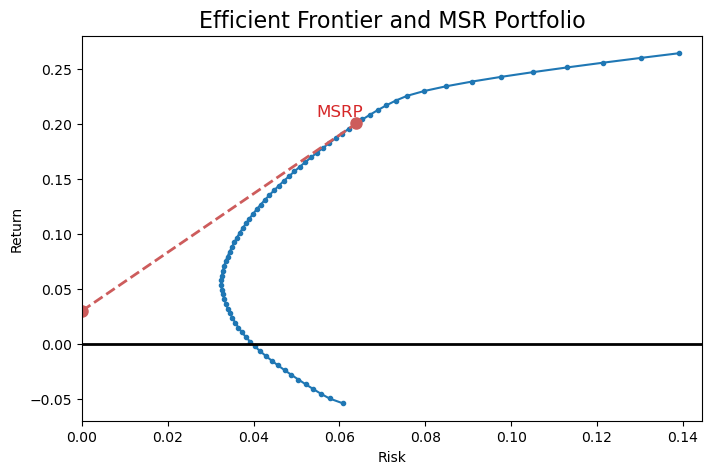

In [36]:
frontier.plot.line(x = "Risk", y = "Return", style = ".-", figsize=(8,5))
plt.title("Efficient Frontier and MSR Portfolio", size = 16)
plt.ylabel("Return")
plt.legend().set_visible(False)
plt.xlim(left=0)

x_vals = [0, vol_msrp]
y_vals = [rf, r_msrp]
plt.plot(x_vals, y_vals, color = 'indianred', marker = 'o', linestyle = 'dashed', linewidth = 2, markersize = 8)
plt.annotate("MSRP", (vol_msrp, r_msrp), color = 'tab:red', textcoords="offset pixels", xytext=(-40, 7), fontsize = 12)

plt.axhline(y = 0, color = 'black',  linewidth = 2)
plt.show()

### Optimal Portfolios: Minimum Variance Portfolio (MVP) <a id="2.3.2"></a>

The last portfolio to estimate is the so called `Minimum Variance Portfolio (MVP)`. This portfolio, which lies on the nose of the efficient frontier, has the property that it obtains the lowest possible risk among all potential portfolios. To understand the practical importance of the MVP, we need to remember that the MSR portfolio may be an optimal choice from a theoretical standpoint. However, finding the MSR portfolio requires *empirical estimates* of the *both* expected returns and the covariance matrix. 

In practice, historical data provide a reasonale estimate of the covariance matrix. However, expected returns are extremely noisy, and estimating them based on historical data is very difficult. This is why characterizing the MSR portfolio in practice is not so easy. On the other hand, the MVP, which *is* on the Markovitz's efficient frontier only requires an estimation of the covariance matrix. 

Here, I first demonstrate the importance of expected returns in cunstructing the MSR portfolio, and then, find the MVP. 

In [37]:
sel    = ["Smoke", "Food"]
w_msrp = msrp(0.03, exp_ret[sel], cov_mat.loc[sel, sel]).x
w2     = msrp(0.03, np.array([.20, .09]), cov_mat.loc[sel, sel]).x
w3     = msrp(0.03, np.array([.21, .08]), cov_mat.loc[sel, sel]).x

In [41]:
print("")
print("                      MSR Portfolio and Expected Returns")
print("=====================================================================================")
print("")
print("Assets included:     ", sel[0], "     and     ", sel[1])
print("")
print("Exp. Returns   :     ", exp_ret[sel][0].round(4), "    and     ", exp_ret[sel][1].round(4))
print("Weights in MSRP:     ", w_msrp[0].round(4), "    and     ", w_msrp[1].round(4))
print("")
print("")
print("Consider a small error in estimating returns:")
print("")
print("Exp. Returns   :     ", 0.20, "       and     ", 0.0900)
print("Weights in MSRP:     ", w2[0].round(4), "    and     ", w2[1].round(4))
print("")
print("")
print("If error went the other way:")
print("")
print("Exp. Returns   :     ", 0.21, "       and     ", 0.0800)
print("Weights in MSRP:     ", w3[0].round(4), "        and     ", w3[1].round(4))


                      MSR Portfolio and Expected Returns

Assets included:      Smoke      and      Food

Exp. Returns   :      0.2093     and      0.0834
Weights in MSRP:      0.9095     and      0.0905


Consider a small error in estimating returns:

Exp. Returns   :      0.2        and      0.09
Weights in MSRP:      0.7088     and      0.2912


If error went the other way:

Exp. Returns   :      0.21        and      0.08
Weights in MSRP:      1.0         and      0.0


One way to achieve the MVP is solve for the MSR in a case where all assets have the same expected return. In this case, the numerator of the Sharpe Ratio is identical for all assets. Therefore, MSR will minimize the volatility. 

In [43]:
n       = cov_mat.shape[0]
w_mvp   = msrp(0.03, np.repeat(0.5, n), cov_mat).x
r_mvp   = w_mvp.T @ exp_ret
vol_mvp = (w_mvp.T @ cov_mat @ w_mvp)**0.5


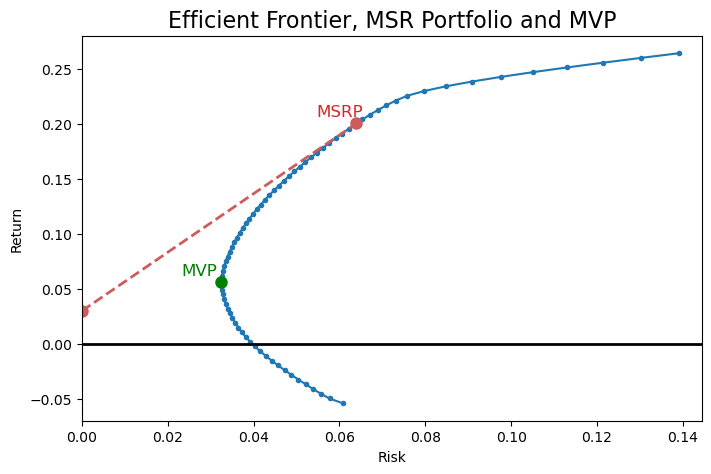

In [45]:
frontier.plot.line(x = "Risk", y = "Return", style = ".-", figsize=(8,5))
plt.title("Efficient Frontier, MSR Portfolio and MVP", size = 16)
plt.ylabel("Return")
plt.legend().set_visible(False)
plt.xlim(left=0)

x_vals = [0, vol_msrp]
y_vals = [rf, r_msrp]
plt.plot(x_vals, y_vals, color = 'indianred', marker = 'o', linestyle = 'dashed', linewidth = 2, markersize = 8)
plt.annotate("MSRP", (vol_msrp, r_msrp), color = 'tab:red', textcoords="offset pixels", xytext=(-40, 7), fontsize = 12)

plt.plot([vol_mvp], [r_mvp], color = 'green', marker = 'o', markersize = 8)
plt.annotate("MVP", (vol_mvp, r_mvp), color = 'green', textcoords="offset pixels", xytext=(-40, 7), fontsize = 12)


plt.axhline(y = 0, color = 'black',  linewidth = 2)
plt.show()

## 3.  Application (2): Stock Indices <a id="3"></a>

The data for the second application is composed of three parts:

* The daily stock returns
* The daily return of the SP500 index
* The 3-Month Treasury Bill

The individual stock and market returns are downloaded from CRSP via [WRDS](https://wrds-www.wharton.upenn.edu/). 
The weekly returns of 3-month Treasury Bill are from the [FRED](https://fred.stlouisfed.org/series/WTB3MS#0). 

The time period for this exercise runs from the beginning of `1990` through the end of `2022`, which is currently the last available data on the `WRDS` website. 


In [7]:
# daily stock returns
stx       = pd.read_csv('Stock-Rets.csv', index_col=0) 
stx.index = pd.to_datetime(stx.index) 
stx.head()

,MSFT,FRC,GM,IIT,ABBV,GOOG,AAPL,UCC,GS,PFE,...,BP,HSBC,NOB,WFC,JPM,SYY,PNC,USB,NXL,SP500
1990-01-02,0.020115,0.018519,0.053254,0.016985,NaN,NaN,0.056738,0.040678,0.000000,0.021583,...,0.000000,NaN,0.005556,0.021922,0.014205,0.035573,0.015015,0.007463,-0.012658,0.017799
1990-01-03,0.005634,-0.018182,-0.005618,-0.008351,NaN,NaN,0.006711,0.029316,0.002545,0.003521,...,0.001912,NaN,-0.044199,-0.009901,-0.002801,-0.026718,0.023669,-0.029630,-0.025641,-0.002586
1990-01-04,0.029412,-0.027778,-0.002825,-0.016842,NaN,NaN,0.003333,-0.006329,0.010152,0.015789,...,0.003817,NaN,-0.011561,0.001667,-0.005618,-0.019608,0.017341,0.000000,0.000000,-0.008613
1990-01-05,-0.024490,0.028571,-0.014164,-0.012848,NaN,NaN,0.003322,0.000000,-0.045226,-0.008636,...,0.005703,NaN,-0.029240,-0.001664,-0.008475,0.000000,-0.008523,-0.022901,0.006579,-0.009756
1990-01-08,0.015342,0.000000,0.002874,-0.010846,NaN,NaN,0.006623,-0.006369,0.015789,-0.008711,...,0.007561,NaN,0.030120,0.003333,-0.002849,-0.008000,-0.002865,-0.015625,-0.006536,0.004514


### Data Preprocessing <a id="3.1"></a>

This dataset, as we will see, requries some cleaning. This is becuase:

1) Missing data in stock returns 
2) T-Bill data are `gross` and `annual` returns 
3) T-Bill data are `weekly` ending on fridays (**frequency mismatch**)
4) Time periods are not the same 

#### Missing Returns
I start my cleaning process by dealing with missing stock data. First we need to find out the number of missing points in each series.

In [61]:
print('Number of missing observations:')
print('============================================')
print('')
for ind in stx.columns:
    if len(stx.index) - np.isreal(stx["FRC"]).sum() != 0:
        print('{:6s} {}'.format(ind , ' has NON numerics!'))
        
    if sum(stx[ind].isna()) > 0:
        print('{:6s} {}  {:4.0f} {} {:4.2f} {}'.format(ind, ':', sum(stx[ind].isna()),
                                                    '(%', sum(stx[ind].isna())/len(stx.index)*100 , ')'))

print('')

Number of missing observations:

FRC    :   811 (% 9.75 )
GM     :   372 (% 4.47 )
ABBV   :  5798 (% 69.73 )
GOOG   :  3691 (% 44.39 )
UCC    :  5957 (% 71.64 )
GS     :  7884 (% 94.82 )
HSBC   :  2411 (% 29.00 )
NOB    :  6080 (% 73.12 )
NXL    :  4863 (% 58.48 )



In this exercise, I simply drop any stock which has more than `10 percent` missing data:  

In [9]:
for ind in stx.columns:
    if sum(stx[ind].isna())/len(stx.index) > 0.10:
        stx.drop(ind, axis = 1, inplace=True)
        

Now, let's deal with the returns of T-Bills. In the first step, I compute weekly net returns from the annual gross returns.

#### Weekly Returns for T-Bills

In [8]:
# 3-M T-Bill returns: weekly and annual returns
tb         = pd.read_csv('WTB3MS.csv' , index_col=0 )
tb.index   = pd.to_datetime(tb.index) 
tb.tail()

,WTB3MS
DATE,
2023-07-14,5.25
2023-07-21,5.26
2023-07-28,5.28
2023-08-04,5.27
2023-08-11,5.29


In [10]:
tb['WTB3MS'] = pd.to_numeric(tb['WTB3MS'], errors='coerce') # returns must be numeric
tb['ret']   = (tb['WTB3MS'].values/100 + 1) ** (1/52) - 1   # compute weekly returns from annual returns
tb.drop('WTB3MS', axis = 1, inplace=True)
tbr = tb
tb.tail()

,ret
DATE,
2023-07-14,0.000984
2023-07-21,0.000986
2023-07-28,0.000990
2023-08-04,0.000988
2023-08-11,0.000992


#### Frequency Mismatch
The third problem is that the stock data is daily. To conduct any analysis, both data should have the same frequency. For this reason, I transofrm the stock data to weekly data on `Friday` of each week, to match the frequency of T-Bill data.

In [11]:
stk = (stx + 1).resample('W-FRI').prod() - 1

#### Time Periods
Last step is to make sure that both dataframes have the same range:

In [83]:
print('{:20s}{}{:14s}{}'.format('', 'Start', '','End'))
print('{:16s}{}{:10s}{}'.format('Stocks Data', stk.index[0].date(), '', stk.index[-1].date())) 
print('{:16s}{}{:10s}{}'.format('T-Bill Data', tb.index[0].date(), '', tb.index[-1].date())) 

                    Start              End
Stocks Data     1990-01-05          2022-12-30
T-Bill Data     1954-01-08          2023-08-11


In [12]:
tb = tb[(tb.index >= stk.index[0]) & (tb.index <= stk.index[-1])].copy()

In [85]:
print('{:20s}{}{:14s}{}'.format('', 'Start', '','End'))
print('{:16s}{}{:10s}{}'.format('Stocks Data', stk.index[0].date(), '', stk.index[-1].date())) 
print('{:16s}{}{:10s}{}'.format('T-Bill Data', tb.index[0].date(), '', tb.index[-1].date())) 

                    Start              End
Stocks Data     1990-01-05          2022-12-30
T-Bill Data     1990-01-05          2022-12-30


### Graphs <a id="3.1.1"></a>


Let's plot these indecies over time:

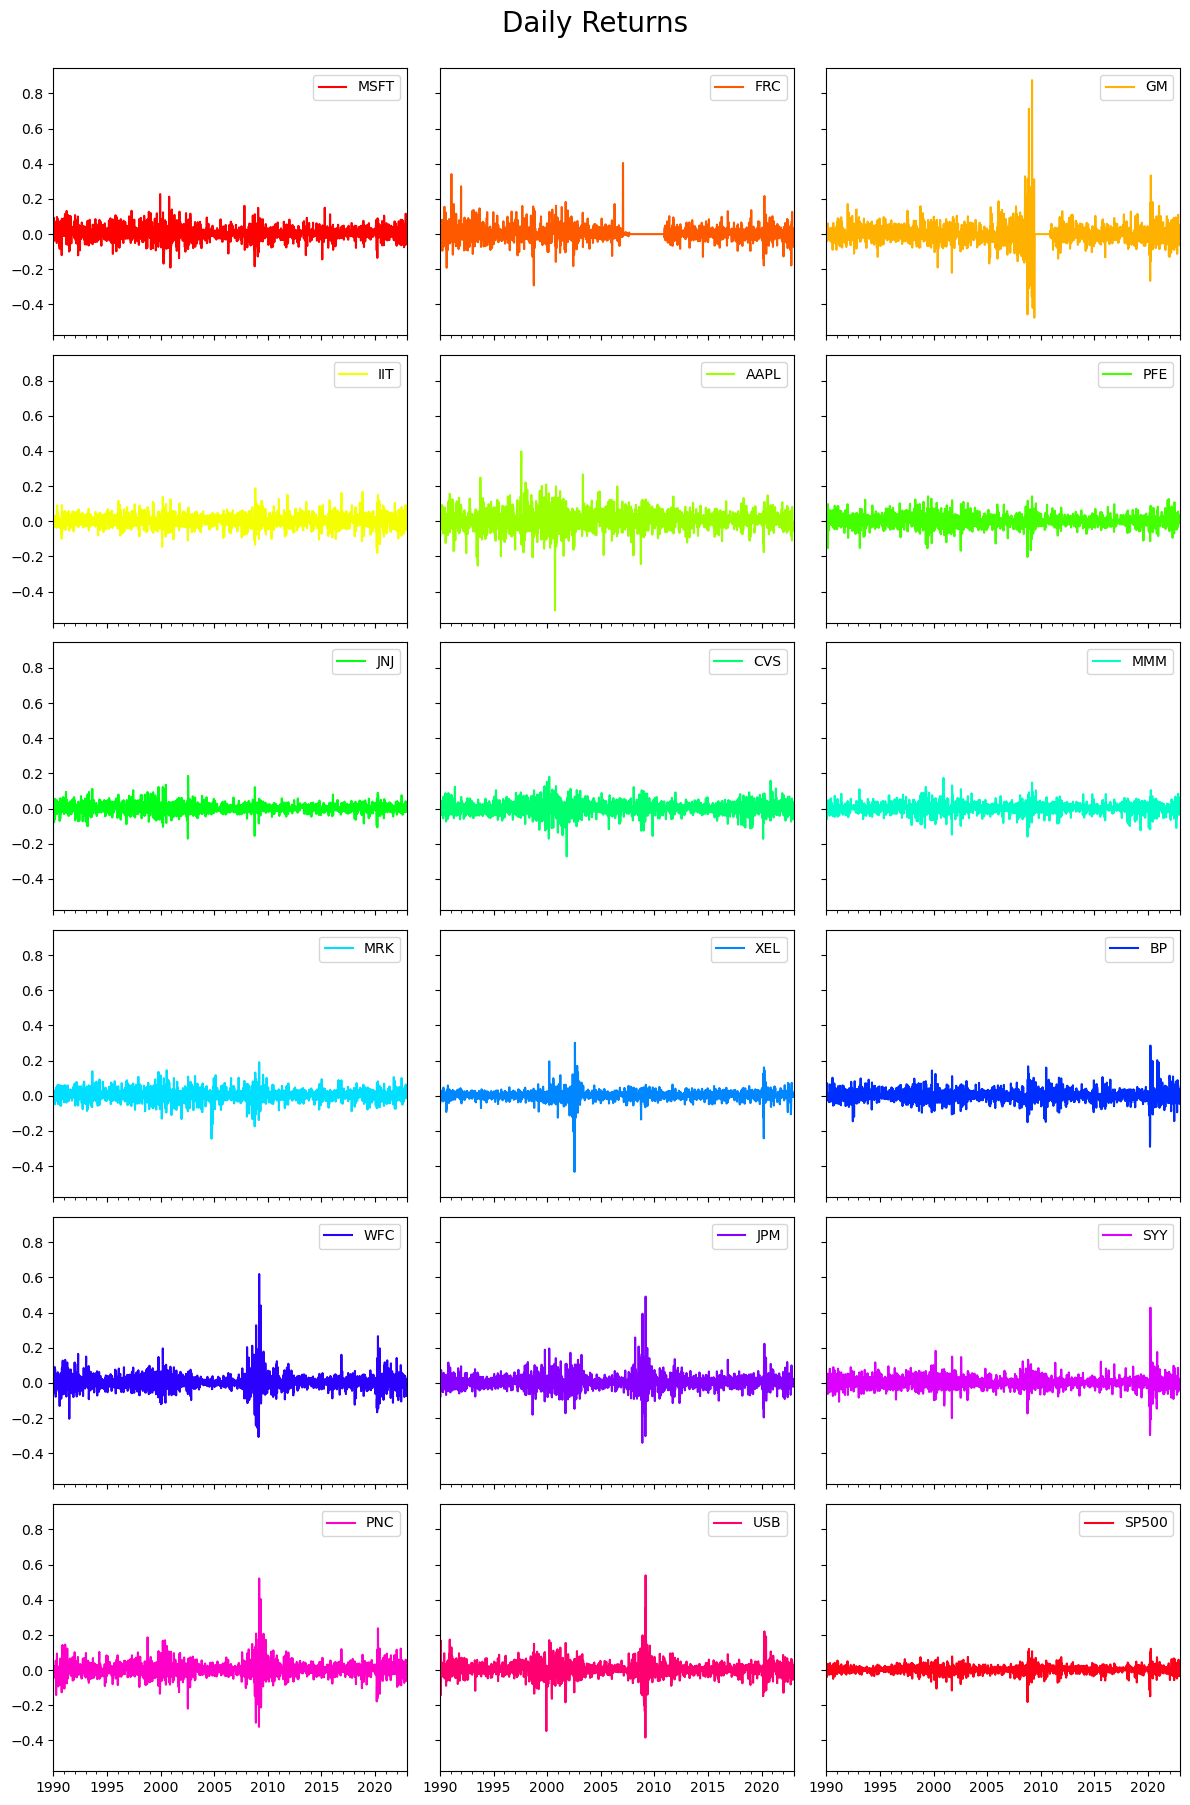

In [72]:
ncol = 3  
nrow = int(np.ceil(len(stk.columns)/ncol)) 

colormap = plt.cm.get_cmap('hsv', ncol*nrow)

fig, axs = plt.subplots(nrows = nrow, ncols = ncol, figsize = (ncol*4, nrow*3), sharey=True, sharex=True)
plt.subplots_adjust(hspace = 0.5, wspace = 0.2)
fig.suptitle("Daily Returns", fontsize = 20, y = 1)


axs = axs.ravel()

for index, ax, i in zip(stk.columns, axs, range(ncol*nrow)):
    stk[index].plot(ax = ax, legend = True, color = colormap(i))
    

fig.tight_layout()
plt.show()

#### T-Bill Returns

<Axes: title={'center': 'Return of 3M T-Bill'}, xlabel='DATE'>

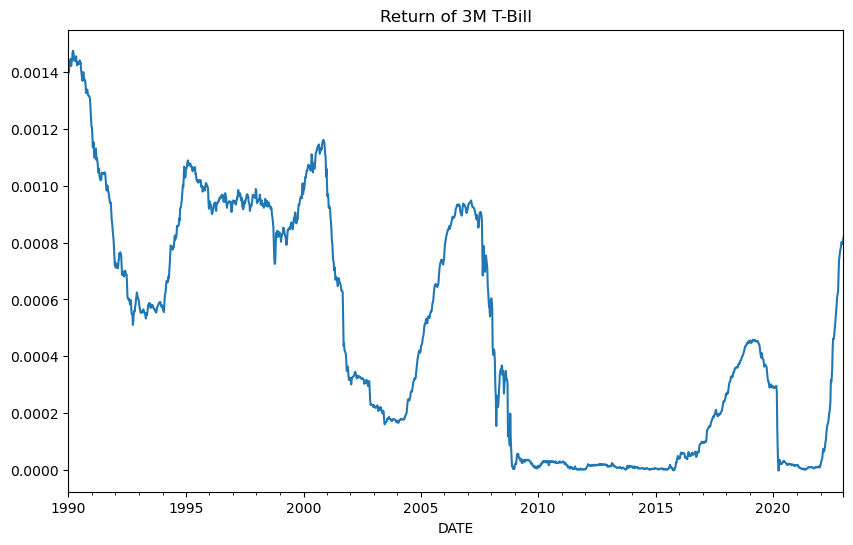

In [86]:
tb['ret'].plot(figsize = (10,6), title = "Return of 3M T-Bill")

<Axes: title={'center': 'Return of 3M T-Bill (entire data)'}, xlabel='DATE'>

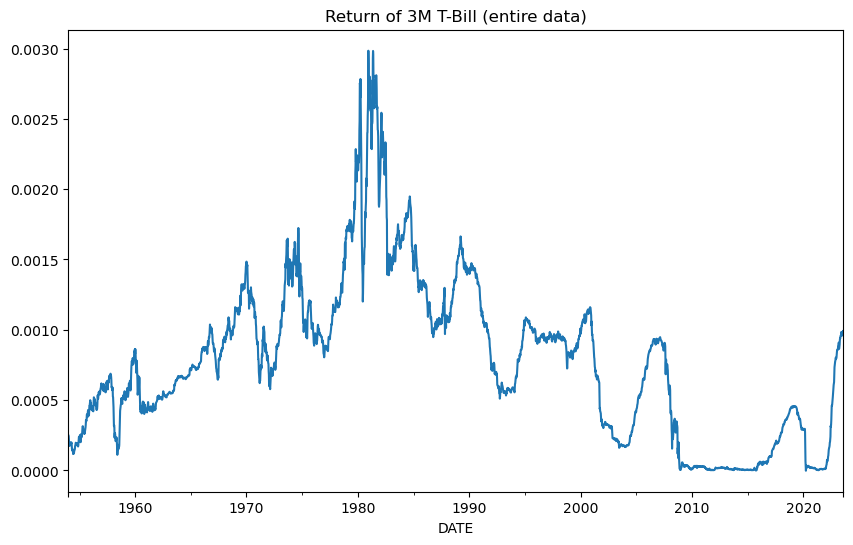

In [88]:
tbr['ret'].plot(figsize = (10,6), title = "Return of 3M T-Bill (entire data)")

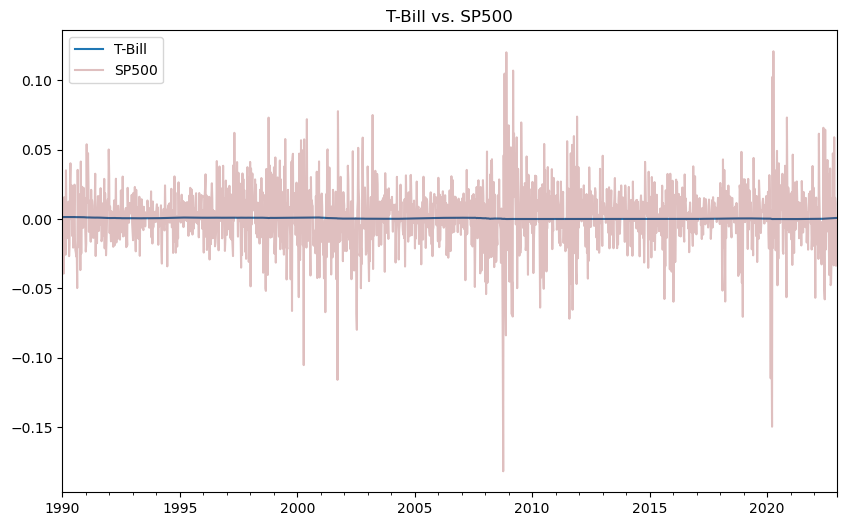

In [13]:
tb['ret'].plot(figsize = (10,6), label = "T-Bill", title = "T-Bill vs. SP500")
stk['SP500'].plot(color = 'maroon', alpha = 0.25, label = "SP500")
plt.xlabel("")
plt.legend()

The last step is to make sure that both the stock and T-bill returns have the same range:


Text(0.5, 1.0, 'Daily returns of the stocks')

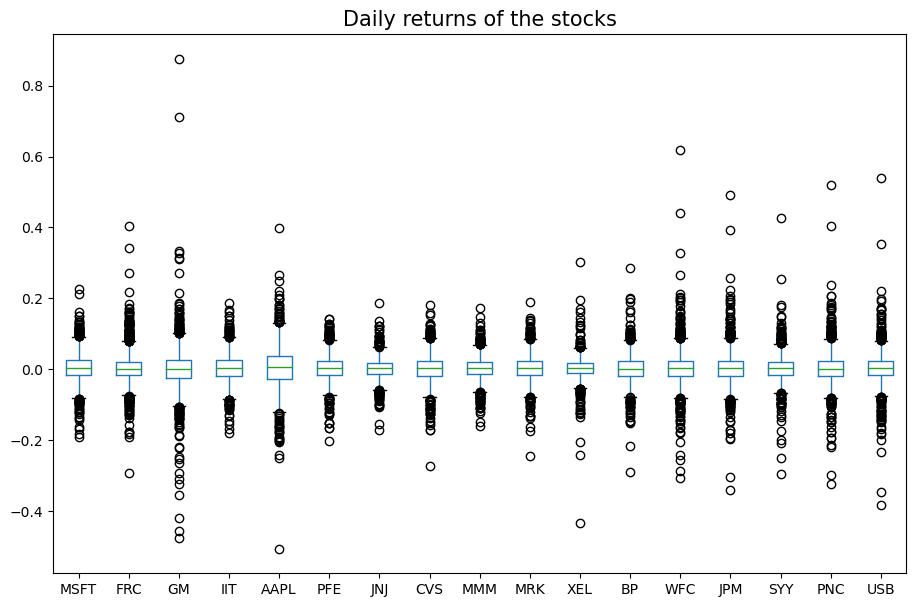

In [222]:
stk.iloc[:,:-1].boxplot(figsize=(11, 7), grid=False)
plt.title("Daily returns of the stocks", fontsize = 15)

Text(0.5, 1.0, 'Daily returns of SP500 Index')

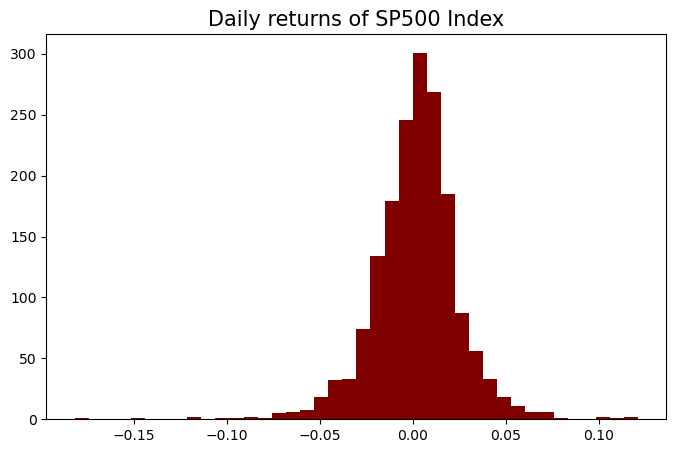

In [228]:
stk['SP500'].hist(bins=40, figsize=(8, 5), grid=False, color = 'maroon')
plt.title("Daily returns of SP500 Index", fontsize = 15)


### Descrpitive and Financial Statistics <a id="3.1.2"></a>


In [90]:
stk.describe().T

,count,mean,std,min,25%,50%,75%,max
MSFT,1722.0,0.004574,0.040613,-0.190349,-0.017673,0.003311,0.025964,0.227696
FRC,1722.0,0.003610,0.043984,-0.291490,-0.017109,0.000000,0.021246,0.404699
GM,1722.0,-0.000239,0.063076,-0.475524,-0.026167,0.000000,0.025175,0.875862
IIT,1722.0,0.003137,0.037489,-0.179383,-0.019161,0.003084,0.024938,0.187934
AAPL,1722.0,0.005303,0.057130,-0.506587,-0.026594,0.005784,0.036486,0.397395
PFE,1722.0,0.002913,0.035874,-0.203159,-0.017526,0.002577,0.022848,0.142330
JNJ,1722.0,0.002680,0.028077,-0.171287,-0.013012,0.002482,0.017744,0.185424
CVS,1722.0,0.002401,0.038434,-0.272501,-0.018527,0.002557,0.023852,0.180328
MMM,1722.0,0.002070,0.030941,-0.160062,-0.014354,0.002261,0.019036,0.173776
MRK,1722.0,0.002542,0.035662,-0.244672,-0.017605,0.002131,0.023270,0.190413


The financial stats that I will compute for each asset are: 
1. Annualized returns
2. Volatility of returns
3. Skewness
4. Kurtosis
5. Value at Risk (VaR)
6. Sharpe Ratio
7. Max drawdown

I compute these statistics from `2011` onward to get a sense of how these indices have performed more recently. 

In [93]:
rm.summary_stats(stk["2011":], freq = 52, riskfree_rate = tb['ret'], rn = 3)

,Annualized Return,Ann. Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
MSFT,22.042,23.213,-0.096,5.419,4.785,6.979,0.220,-35.046
FRC,13.456,27.211,-0.053,7.011,5.638,8.391,0.135,-48.489
GM,-0.756,35.287,0.454,8.215,6.773,10.283,-0.008,-60.680
IIT,13.636,29.922,-0.004,5.087,6.318,8.706,0.136,-47.700
AAPL,23.929,28.185,-0.079,4.364,5.914,8.065,0.239,-43.636
PFE,13.802,21.383,0.094,4.867,4.390,6.319,0.138,-34.259
JNJ,12.272,15.863,-0.281,5.364,3.436,4.749,0.123,-20.554
CVS,10.872,24.258,-0.225,5.433,5.320,7.581,0.109,-49.168
MMM,5.749,20.924,-0.577,5.144,4.951,7.173,0.057,-51.309
MRK,14.001,20.077,0.008,4.093,4.218,6.024,0.140,-21.459


In [94]:
rm.summary_stats(tb["2011":], freq = 52, riskfree_rate = tb['ret'], rn = 3)

,Annualized Return,Ann. Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
ret,0.66,0.129,1.602,5.01,0.007,-0.0,0.007,-0.0


### Factorability Tests <a id="3.1.3"></a>

The last test I conduxt aims to verify that the correlations between these indices are indeed statistically significant. A variance-covariance matrix is called `factorable` if  it includes multiple significant correlations. If none of the correlations are significantly different from zero, then we should not perform any statistical analysis on the data. Here, I use two different tests for this purpose:
 
1) Bartlett’s Test of sphericity
   Bartlett’s test of sphericity compares an observed correlation matrix to the identity matrix. The `null hypothesis` of the test is that the variables are orthogonal, i.e. `not correlated`. The alternative hypothesis is that the variables are correlated enough for the correlation matrix to diverge significantly from the identity matrix. The test statistic has a Chi-Square distribution and its degree of freedom is equal to the number of variables in the matrix. 
   
2) Kaiser-Meyer-Olkin (KMO) Test
   This Test was first introduced by Henry Kaiser as a `measure of sampling adequacy (MSA)` for factor analysis, and then further extended by Kaiser and Rice in 1974. The Kaiser-Meyer-Olkin (KMO) Test is a measure of how suited the data is for `Factor Analysis`. The test measures sampling adequacy for each variable in the model and for the complete model. The statistic is a measure of the *proportion of variance among variables that might be common variance*. The lower the proportion, the more suited the data for `Factor Analysis`. KMO returns values between 0 and 1. As a rule of thumb, values between 0.8 and 1 indicate the sampling is adequate while values less than 0.6 are usually considered inadequate. 
   
$$
KMO_j = \frac{\sum_{i \neq j} r_{ij}^2}{\sum_{i \neq j} r_{ij}^2 + \sum_{i \neq j} p_{ij}^2}
$$

where 
* $r_{ij}$ is the correlation between the variable in question and other variables
* $p_{ij}$ is the partial correlation between the variable in question and other variables

In [95]:
print('Bartlett Sphericity Test:')
print('==============================')
print('       Null:  No correlation')
print('       Stat: ', np.round(calculate_bartlett_sphericity(stk)[0], 2))
print('       Pval: ', np.round(calculate_bartlett_sphericity(stk)[1], 3))

Bartlett Sphericity Test:
       Null:  No correlation
       Stat:  14408.72
       Pval:  0.0


In [120]:
print('KMO Overall Score: ', np.round(calculate_kmo(stk)[1], 2))

KMO Overall Score:  0.95


## Efficient Frontier Analysis <a id="3.2"></a>

I build on our previous review of the optimal portfolio theory to 

1. First compute the optimal weights for a random return target
2. Plot the entire efficient frontier. 

In [97]:
# expected returns excluding market portfolio
exp_ret = rm.annualize_rets(stk.iloc[:,:-1], 52).copy()

# annualized sample weekly variance-covariance matrix
cov_mat = stk.iloc[:,:-1].cov() * 52 

In [113]:
print('Variance-Covaraince Matrix:')
print('==================================')
print('{:10s}{:10s}{:9s}{:7s}'.format('','Min', '', 'max'))
print('{:8s}{}{:12s}{}'.format('',round(np.min(np.min(cov_mat)),5), '', round(np.max(np.max(cov_mat)),5)))



Variance-Covaraince Matrix:
          Min                max    
        0.00979            0.20689


In [132]:
# a random target 
target  = 0.12
weights = min_vol(target, exp_ret, cov_mat).x

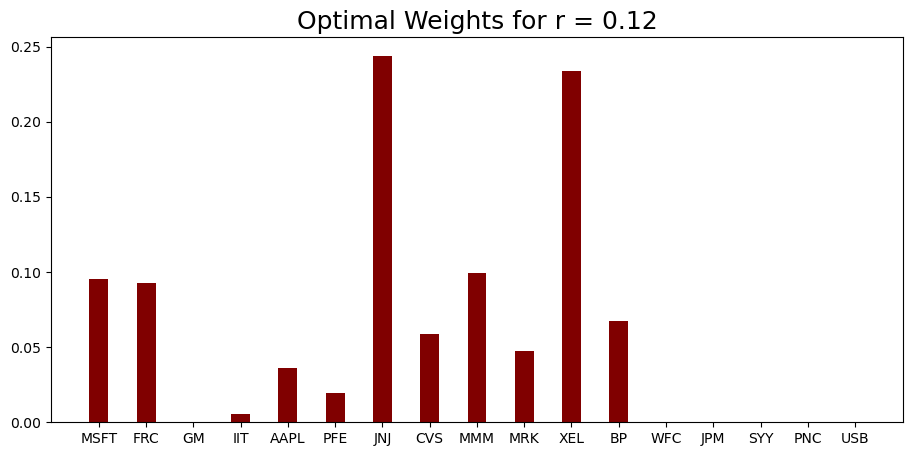

In [133]:
fig = plt.figure(figsize = (11,5))

plt.bar(stk.columns[:-1],
        weights,
        color = 'maroon',
        width = 0.4)
plt.title("Optimal Weights for r = " + str(target), fontsize = 18)
plt.show()

In [150]:
# number of points in the grid for returns
n_points = 75    

# dataframe of frontier points
frontier = pd.DataFrame(columns = ["Return", "Risk"], index = range(n_points))

# grid for returns
ret_grid  = np.linspace(exp_ret.min(), exp_ret.max(), n_points)

# efficient frontier
for i, r in zip(range(n_points), ret_grid):
    
    solution                  = min_vol(r, exp_ret, cov_mat)
    frontier.loc[i, "Return"] = solution.x.T @ exp_ret
    frontier.loc[i, "Risk"]   = solution.fun



# risk-free rate
rf      = (1 + tb["ret"].mean())**52 - 1


# MSRP
w_msrp   = msrp(rf, exp_ret, cov_mat).x
r_msrp   = w_msrp.T @ exp_ret
vol_msrp = (w_msrp.T @ cov_mat @ w_msrp)**0.5


# MVP
n       = cov_mat.shape[0]
w_mvp   = msrp(0.03, np.repeat(0.5, n), cov_mat).x
r_mvp   = w_mvp.T @ exp_ret
vol_mvp = (w_mvp.T @ cov_mat @ w_mvp)**0.5
    

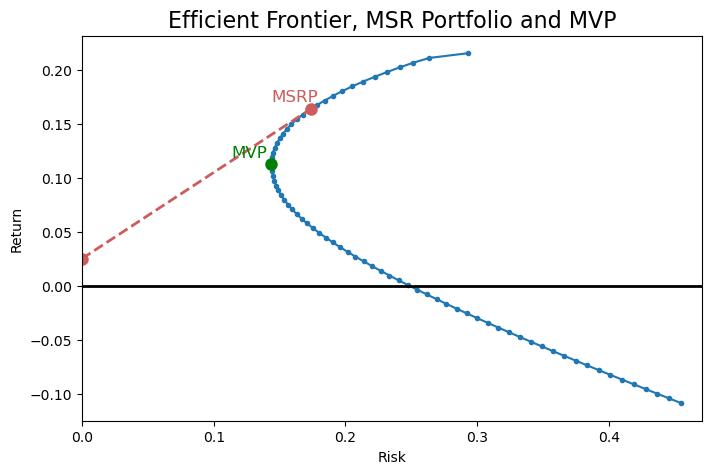

In [154]:
frontier.plot.line(x = "Risk", y = "Return", style = ".-", figsize=(8,5))
plt.title("Efficient Frontier, MSR Portfolio and MVP", size = 16)
plt.ylabel("Return")
plt.legend().set_visible(False)
plt.xlim(left=0)

x_vals = [0, vol_msrp]
y_vals = [rf, r_msrp]
plt.plot(x_vals, y_vals, color = 'indianred', marker = 'o', linestyle = 'dashed', linewidth = 2, markersize = 8)
plt.annotate("MSRP", (vol_msrp, r_msrp), color = 'indianred', textcoords="offset pixels", xytext=(-40, 7), fontsize = 12)
plt.plot([vol_mvp], [r_mvp], color = 'green', marker = 'o', markersize = 8)
plt.annotate("MVP", (vol_mvp, r_mvp), color = 'green', textcoords="offset pixels", xytext=(-40, 7), fontsize = 12)
plt.axhline(y = 0, color = 'black',  linewidth = 2)

plt.show()


In the last part of this section, I want to see how weights of different stocks vary with the target return:

In [186]:
ret_grid  = np.linspace(rf, exp_ret.max(), n_points)

weights = pd.DataFrame(columns = stk.columns[:-1], index = ret_grid)

for i, r in zip(range(n_points), ret_grid):
    weights.iloc[i,:] = min_vol(r, exp_ret, cov_mat).x



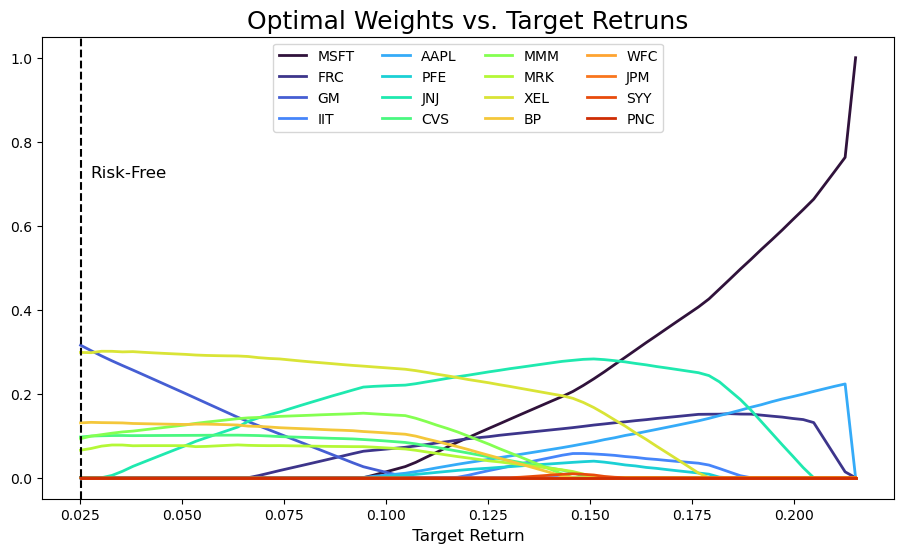

In [204]:
    
colormap = plt.cm.get_cmap('turbo', 5*len(weights.columns))

fig = plt.figure(figsize = (11, 6))

for index, i in zip(weights.columns, range(len(weights.columns)-1)):
    plt.plot(weights[index], label = index, color = colormap(5*i-1), linewidth = 2)
    


plt.title("Optimal Weights vs. Target Retruns", fontsize = 18)
plt.xlabel(" Target Return " , fontsize = 12)

plt.axvline(x = rf, color = 'black',  linewidth = 1.5, linestyle = '--')
plt.annotate("Risk-Free", (rf, 0), color = 'black', textcoords = "offset pixels", xytext = (10, 300), fontsize = 12)

plt.legend(ncol = 4)
plt.show()

Conclusions:

* For almost all potential targets, the number of effective assets is noticeably small
* Best assets for various return ranges are different  



In [212]:
print("Best Assets:")
print("===================================")
print('{:3s}{:18s}{}'.format('','Lower Returns:', 'XEL   and  GM' ))
print('{:3s}{:18s}{}'.format('','Moderate Returns:', 'JNJ   and  XEL' ))
print('{:3s}{:18s}{}'.format('','Higher Returns:', 'AAPL  and  MSFT' ))

Best Assets:
   Lower Returns:    XEL   and  GM
   Moderate Returns: JNJ   and  XEL
   Higher Returns:   AAPL  and  MSFT



## Diversification in Practice <a id="3.3"></a>

This last section studies the practical consequences of using the optimal portfolio theory. The concept of `Diversification`, which is at the heart of this theory relies on our ability to diversify away unrewarded idiosyncratic risk. In this sense, an *optimal* portfolio should improve return-to-risk ratio. It's been proven that this strategy is specially ineffectice during *crasehs*; simply becauase we can't diversify the systemic risk away. As a result, in practice `Hedging` and `Insurance` investment strategies are used.

That said, one could expect that an *optimal* portfolio should perform at least better than a naive portfolio. To see if this is ture, in the following exercise, I compare four portfolios perform:

* An optimal (MSR) portfolio formed at the end of `2012`, and kept through the end of `2022`.
* An optimal (MVP) portfolio formed at the end of `2012`, and kept through the end of `2022`.
* An equally-weighted portfolio (EWP) formed at the end of `2012`, and kept through the end of `2022`.
* The Market Portfolio (SP500) during the same period.

Let's form these portfolios:


In [253]:
# risk-free rate
rf = (1 + tb.loc[:"2012","ret"].mean())**52 - 1

# expected returns and covariance matrix 
ert = rm.annualize_rets(stk.loc[:"2012",:], 52)
cov = stk.loc[:"2012", :].cov() * 52 

# excluding SP500
exp_ret = ert[:-1].copy()
cov_mat = cov.iloc[:-1,:-1].copy()


w_msr = msrp(rf, exp_ret, cov_mat).x
w_mvp = msrp(rf, np.repeat(0.5, covmat.shape[0]), cov_mat).x
w_ewp = np.repeat(1.0/cov_mat.shape[0], cov_mat.shape[0])

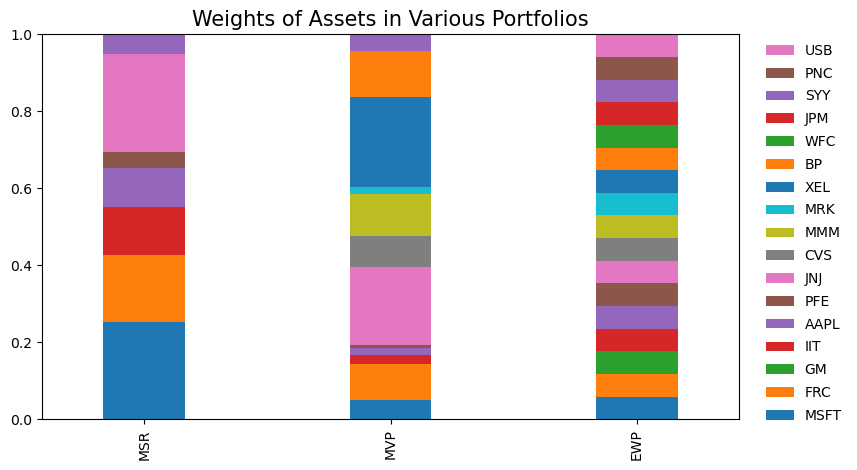

In [362]:
wts = pd.DataFrame({
    "MSR": w_msr,
    "MVP": w_mvp,
    "EWP": w_ewp}, index = stk.columns[:-1])


wts.T.plot.bar(figsize=(9, 5), legend = True, width = 0.330, stacked=True)
plt.title("Weights of Assets in Various Portfolios", fontsize = 15)
plt.legend(bbox_to_anchor=(1.02, 0.06), loc='upper left', labelspacing = -2.65, frameon = False)

Assume that we invest `100 USD` in each of these portfolios. What happens if we don't change our position till the end of 2022?

In [379]:
def wealth_track(w, r, m):
    """
    Input:
        w: weights of assets in the portfolio (np.array)
        r: return of each asset over time     (dataframe)
        m: initial wealth
        
    Output:
        A dataframe with the same index of r, contains:
            * wealth at each point in time
            * portfolio return at each point in time    
    """
    n = len(w)
    if len(r.columns) != n:
        print("Error: dimension of weights and returns do NOT match!")
    
    prf = pd.DataFrame(columns = ["Wealth", "Return"], index = r.index)
    
    prf.loc[r.index[0] , "Wealth"] = m
    prf.loc[r.index[0] , "Return"] = 0.0
        
        
    for period in range(1, len(r.index[1:])):
        prf.loc[r.index[period] , "Return"] = w @ (1 + r.loc[r.index[period-1],:]) - 1
        prf.loc[r.index[period] , "Wealth"] = w @ (1 + r.loc[r.index[period-1],:]) * prf.loc[r.index[period-1], "Wealth"]
            
    
    return prf

In [380]:
initial_wealth = 100

# simulation period with DAILY retruns
rets    = stx.loc["2013":, :]
stk_ret = rets.iloc[:, :-1].copy()
SP500_r = pd.DataFrame(data = rets.iloc[:, -1], columns = ["SP500"], index = stk_ret.index)


# performance of each portfolio
prf_msr = wealth_track(w_msr, stk_ret, initial_wealth)
prf_mvp = wealth_track(w_mvp, stk_ret, initial_wealth)
prf_ewp = wealth_track(w_ewp, stk_ret, initial_wealth)
prf_sp500 = wealth_track([1], SP500_r, initial_wealth)


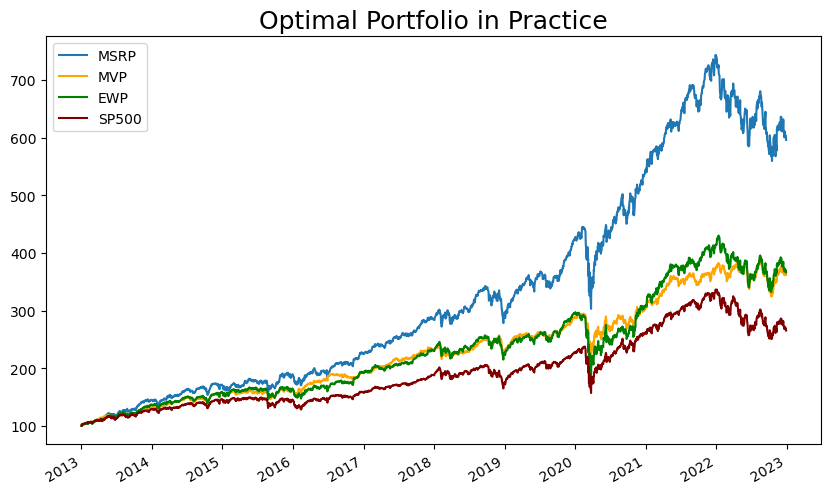

In [419]:
prf_msr["Wealth"].plot(figsize = (10, 6), label = "MSRP", color = "tab:blue")
# prf_msr["Wealth"].rolling(window = 60).mean().plot(color = "tab:blue", legend = False)

prf_mvp["Wealth"].plot(label = "MVP", color = "orange")
# prf_mvp["Wealth"].rolling(window = 60).mean().plot(color = "orange", legend = False)

prf_ewp["Wealth"].plot(label = "EWP", color = "green")
# prf_ewp["Wealth"].rolling(window = 60).mean().plot(color = "green", legend = False)


prf_sp500["Wealth"].plot(label = "SP500", color = "maroon")
# prf_sp500["Wealth"].rolling(window = 60).mean().plot(color = "maroon", legend = False)

plt.title("Optimal Portfolio in Practice", fontsize = 18)
plt.legend()

In [399]:
rf = (1 + tb.loc["2013":,"ret"].mean())**52 - 1

# number of periods in a year
ppy = rm.periods_per_year(prf_msr)

# dataframe of all returns
my_rets = pd.DataFrame({
                        "MSR": prf_msr["Return"].values[:-1],
                        "MVP": prf_mvp["Return"].values[:-1],
                        "EWP": prf_ewp["Return"].values[:-1],
                      "SP500": prf_sp500["Return"].values[:-1]
                        }, index = prf_msr.index[:-1]) 


In [406]:
print("                                         Performance of Optimal Portfolios")
print("==========================================================================================================")
rm.summary_stats(my_rets, freq = ppy, riskfree_rate = rf, rn = 3)

                                         Performance of Optimal Portfolios


,Annualized Return,Ann. Volatility,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic VaR (5%),Sharpe Ratio,Max Drawdown
MSR,19.564,18.718,-0.135,14.989,1.621,2.791,0.196,-31.936
MVP,13.739,15.783,-0.363,21.938,1.299,2.323,0.137,-31.966
EWP,13.878,18.348,-0.426,20.328,1.574,2.737,0.139,-38.316
SP500,10.260,17.591,-0.547,18.438,1.598,2.731,0.103,-33.925


## 4.  Empirical Asset Pricing Models <a id="4"></a>

The last section of this notebook builds on theoretical frameworks that were discussed earlier to estimate the stock prices. However, to keep this introduction short, instead of going to the details, I will just mention that a market with well-diversified portfolios allows us to express the (expected) return of an asset as a function of the (expected) return of the market. This intuition, which seems rather trivial, is at the heart of most empirical asset pricing models. In this short reviwe, I first introduce the Capital Asset Pricing Model (CAPM) and two of its important extensions: 3- and 5-factor Fama-French models. Then, I use real-world data to estimate the parameters of these models.



### Capital Asset Pricing Model (CAPM) 

This model -also known as the one factor model- is derived from the optimal portfolio theory. The CAPM theory suggests that the expected return of any individual asset -or, portfolio of assets- ($\mathbb{E} R_i$) in excess of the risk-free rate is a fraction of the expected return of the market ($\mathbb{E} R_m$) in excess of the risk-free rate:

$$
\mathbb{E} R_i = R_f + \beta_i (\mathbb{E} R_m - R_f)
$$

One can re-write this equation as an estimatable regression function where $\varepsilon$ captures all the forecast error. 
 
$$
R_i - R_f = \alpha_i + \beta_i (\mathbb{E} R_m - R_f) + \varepsilon
$$

We can use data to estimate both parameters of this formulation of the CAPM. The coefficient of this regression line, which is known as the asset's *beta* is, therefore, given by

$$
\beta_i = \frac{Cov(R_i,R_m)}{Var(R_m)}
$$


The beta measures the riskiness of an asset with respect to the entire market. If a stock is riskier than the market, its beta is greater than one. The stock's expected return depends on the asset's correlation with the market, $\beta_i$ and the `market risk premium`, which is the expected market return above the risk-free rate. 

On the other hand, we can interpret $\alpha_i$ as the expected excess return of the asset after taking into account the contribution of the market risk premium. An asset -or a portfolio- with a high $\alpha_i$ would deliver, in expectation, a higher return compared to another asset with a silimar load on market. For this reason, high `alpha` for a portfolio is associated with the manger's skill to generate better returns.  



### Fama-French Three Factor Model 
Despite high expectation, the basic CAPM model was not very successful in explaining the difference between assets' historical returns. To improve its empirical explanatory power, Fama and French (1993) rintroduced an extension of the CAPM where, in addition to the market risk permium, they account for two additional factors: `size permium` and `value premium`. Fama and French conduct a behavioral analysis of the market, which showed that small cap stocks usually overperform big companies. Similarly, they observe that high value stocks tend to outperform low value stocks. Thus, they augmented the CAPM regression and introduced the following model:

$$
\mathbb{E}(R_i - R_f) = \alpha_i + \beta_{i,m} \mathbb{E}( R_m - R_f) + \beta_{i,s} \mathbb{E}SMB + \beta_{i,v} \mathbb{E}HML 
$$

or, 

$$
R_i - R_f = \alpha_i + \beta_{i,m} \mathbb{E}( R_m - R_f) + \beta_{i,s} \mathbb{E}SMB + \beta_{i,v} \mathbb{E}HML + \varepsilon
$$

where 
* SMB (small - big) isthe return on a diversified portfolio of small-cap stocks minus the return on a diversified portfolio of big-cap stocks. In effect this is the size permium. One way to capter this factor is to measure the diffference between the return of the bottom 10 percent small cap stocks and the top 10 percent big cap stocks

* HML (high - low) is the difference between the returns on diversified portfolios of stocks. In effect, this is the value premium. To capture this factor, one can consider the the gap beween the return of the top 10 percent high value and the bottom 10 percent small low value stocks
    * the `value` of a stock referes to its `book-to-market` ratio

In the above equation
* $\alpha$ is the expected return of the portfolio in excess of the impact of its factors.
* $\beta_i$ captures the impact of factor $i$, or *factor premium*, which is a reqard for being exposed to a factor $i$.
* $\varepsilon$ is the residual that remains unexplained.

**Note**:
In addition to the empirical analysis, Fama and French's focus on size and value stocks is rooted in the optimal portfolio theory.
* the optimal portfolio theory implies that a market cap-weighted portfolio is efficient.
* empirical investigations have shown many times that this is not the case. But why? 
* market portfolio is biased towards large companies (by definition they get higher weights) and growth stocks (which, by definition, have strong earning growth numbers and are often large).
* Therefore, they conclude that, these two issues are behind the inefficiency of a cap-weighted portfolio. This is why Fame and French were motivated to examine the impact of these factors. 

### Fama-French Five Factor Model 
The Fama French five-factor model (2015), is an improvment upon their three-factor model, which introduces two additional factors to the equation:

$$
R_i - R_f = \alpha_i + \beta_{i,m} \mathbb{E}( R_m - R_f) + \beta_{i,s} \mathbb{E}SMB + \beta_{i,v} \mathbb{E}HML + \beta_{i,r} \mathbb{E}SMW + \beta_{i,c} \mathbb{E}CMA + \varepsilon
$$

where 

* SMW (strong - weak) is the difference between the returns on diversified portfolios of stocks with robust (high and steady) and weak (low) profitability.
* CMA (conservative - aggressive) is the difference between the returns on diversified portfolios of the stocks of low and high investment firms.
    * low(high) investment refers to the reinvestment ratio of a firm.

One could imagaine many extensions of the CAPM with multiple factors. Generally speaking, factors are risky variables that are rewarded in the return of an asset or a portfolio. There are three braod types of factors:

1. Macroeconomic Factors 
    * These factors such as inflation, growth rate have usually major impacts on asset prices. However, they are not very useful tools in asset allocation because it would be extremely difficult to find an asset that responds differently -compared to other assets- to such factors. 
    
2. Statistical (Implicit) Factors 
    * These factors may or may not be identificable. We may find persistent or recurring trends in the data that suggest certain asset prices rise or fall. However, specially if these factors are not identifiable, it would be difficult to design a portfolio based on them.
    
3. Intrinsic Factors 
    * Most of the existing empirical extensions are based on these factors -e.g., value, size, volatility, momentum. These are factors that we can use in designing a portfolio.

In general, a factor model decomposes a portfolio return by attributing it to various factor/characteristics of the underlying assets:

$$
R_i - R_f = \alpha_i + \beta_1 F_1 + \beta_2 F_2 + \beta_3 F_3 + \ldots + \varepsilon
$$

where 


* $\alpha$ is the expected return in excess of the impact of its factors.
* $\beta_i$ captures the impact of factor $i$.
* $\varepsilon$ is the residual that remains unexplained.
 


### Capital Asset Pricing Model (CAPM)  <a id="4.1"></a>
I estimate the basic CAPM with the stock returns.

In [199]:
excess_ret = stk.subtract(tb['ret'], axis = 0)      # excess returns
stk_ex_ret = excess_ret.iloc[:, :-1].copy()         # stock excess return
mkt_ex_ret = excess_ret.iloc[:, -1].copy()          # market excess return

# dataframe of paramaters
params = pd.DataFrame(columns = ["Alpha", "Beta"], index = stk.columns[:-1])

X   = sm.add_constant(mkt_ex_ret.values.reshape(-1, 1)) # rhs of regression

for ind in params.index:
    
    res = sm.OLS(stk_ex_ret[ind].values.reshape(-1, 1), X).fit() 
    
    params.loc[ind , "Alpha"] = np.round(res.params[0], 4)
    params.loc[ind , "Beta"]  = np.round(res.params[1], 4)
    

In [142]:
print('CAPM Parameters for Stocks:')
print('========================================================')
params.T

CAPM Parameters for Stocks:


,MSFT,FRC,GM,IIT,AAPL,PFE,JNJ,CVS,MMM,MRK,XEL,BP,WFC,JPM,SYY,PNC,USB
Alpha,0.0029,0.0023,-0.0024,0.0014,0.0036,0.0015,0.0015,0.001,0.0006,0.0013,0.001,0.0006,0.0011,0.001,0.0013,0.001,0.0011
Beta,1.0125,0.7149,1.4144,1.0243,1.0735,0.7968,0.6008,0.7472,0.8354,0.6847,0.5215,0.8265,1.2755,1.356,0.8908,1.2153,1.1381


In [200]:
# to be comparable with future models, I adjust the time period & use RF from Fama-French dataset
Y = (stk.loc["1990-07":"2022-12",'MSFT'] - ff3_w.loc["1990-07":"2022-12",'RF']).values.reshape(-1, 1)
m = ff3_w.loc["1990-07":"2022-12",'Mkt-RF'].copy()
X = sm.add_constant(m.values.reshape(-1, 1))    # rhs of regression
result1 = sm.OLS(Y, X).fit() 

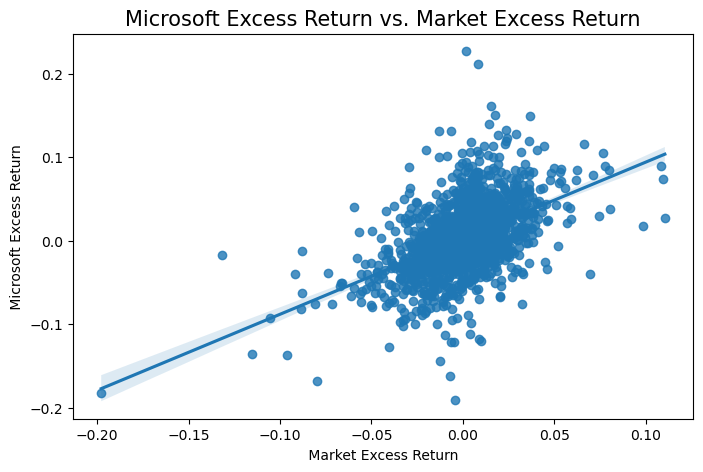

In [201]:
plt.figure(figsize = (8,5))
sns.regplot(x=m, y=Y)
plt.xlabel(" Market Excess Return ")
plt.ylabel(" Microsoft Excess Return ")
plt.title("Microsoft Excess Return vs. Market Excess Return", fontsize = 15)
plt.show()

In [202]:
print('CAPM Parameters for Microsoft:')
print('========================================================')
print(result1.summary())

CAPM Parameters for Microsoft:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     566.4
Date:                Fri, 18 Aug 2023   Prob (F-statistic):          3.01e-108
Time:                        14:41:09   Log-Likelihood:                 3275.4
No. Observations:                1696   AIC:                            -6547.
Df Residuals:                    1694   BIC:                            -6536.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028

### 3-Factor Fama-French Model <a id="4.2"></a>
To estimate both 3- and 5-factor models, I use daily data from developed market, which is obtained [this](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) webpage. Both datasets run from `07-1999` to `06-2023`. The only issue is to transfom our daily factors to weekly to match the stock data.

In [42]:
ff3 = pd.read_csv("FF_3_D_Factors.csv", header = 0, index_col = 0, na_values = -99.99)/100
ff3.index = pd.to_datetime(ff3.index, format = "%Y%m%d").to_period('D')
ff3.head()

,Mkt-RF,SMB,HML,RF
1990-07-02,0.0069,-0.0006,-0.0033,0.0003
1990-07-03,0.0018,0.0007,-0.0015,0.0003
1990-07-04,0.0062,-0.0017,-0.0017,0.0003
1990-07-05,-0.0074,0.0029,0.0014,0.0003
1990-07-06,0.0020,-0.0017,0.0002,0.0003


In [203]:
ff3_w       = (ff3 + 1).resample('W').prod() - 1  # match frequency
ff3_w       = ff3_w["1990-07":"2022-12"].copy()   # same period as stock data
ff3_w.index = stk["1990-07":"2022-12"].index      # same index as stock data

In [204]:
stk_ex_ret = stk["1990-07":"2022-12"].subtract(ff3_w['RF'], axis = 0).iloc[:, :-1].copy()     # stock excess return
fac_prem_3 = ff3_w[['Mkt-RF', 'SMB', 'HML']].copy()                                           # factor premiums


# dataframe of paramaters
params = pd.DataFrame(columns = ["Alpha", "Beta_market", "Beta_size", "Beta_value"],
                      index   = stk.columns[:-1])

X  = sm.add_constant(fac_prem_3.values).reshape(-1, 4) # rhs of regression

for ind in params.index:
    
    res = sm.OLS(stk_ex_ret[ind].values.reshape(-1, 1), X).fit() 
    
    params.loc[ind , "Alpha"]        = np.round(res.params[0], 4)
    params.loc[ind , "Beta_market"]  = np.round(res.params[1], 4)
    params.loc[ind , "Beta_size"]    = np.round(res.params[2], 4)
    params.loc[ind , "Beta_value"]   = np.round(res.params[3], 4)
    
    

In [126]:
print('Fama-French 3-Factor Model Parameters for Stocks:')
print('========================================================')
params.T

Fama-French 3-Factor Model Parameters for Stocks:


,MSFT,FRC,GM,IIT,AAPL,PFE,JNJ,CVS,MMM,MRK,XEL,BP,WFC,JPM,SYY,PNC,USB
Alpha,0.0034,0.0023,-0.0029,0.0012,0.0042,0.0019,0.0017,0.001,0.0004,0.0013,0.001,-0.0001,0.0003,0.0006,0.0011,0.0006,0.0006
Beta_market,0.8082,0.7607,1.3978,1.0557,1.0088,0.6142,0.4165,0.6441,0.7775,0.5145,0.4451,1.0037,1.1995,1.2262,0.8625,1.1071,1.0228
Beta_size,-0.613,0.4013,-0.415,0.0278,0.0288,-0.7469,-0.7351,-0.4483,-0.378,-0.9195,-0.5285,0.022,-0.8121,-0.8968,-0.2408,-0.6983,-0.8269
Beta_value,-0.9633,0.2463,0.6349,0.5366,-0.9018,-0.3011,-0.1499,0.1065,0.2956,-0.0378,0.2744,0.8431,1.3056,0.8685,0.4046,1.0331,1.1172


In [205]:
result2 = sm.OLS(stk_ex_ret['MSFT'].values.reshape(-1, 1), X).fit() 
print('Fama-French 3-Factor Model Parameters for Microsoft:')
print('========================================================')
print(result2.summary())

Fama-French 3-Factor Model Parameters for Microsoft:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     281.1
Date:                Fri, 18 Aug 2023   Prob (F-statistic):          4.78e-148
Time:                        14:41:18   Log-Likelihood:                 3373.8
No. Observations:                1696   AIC:                            -6740.
Df Residuals:                    1692   BIC:                            -6718.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

### 5-Factor Fama-French Model <a id="4.3"></a>

In [181]:
ff5 = pd.read_csv("FF_5_D_Factors.csv", header = 0, index_col = 0, na_values = -99.99)/100
ff5.index = pd.to_datetime(ff5.index, format = "%Y%m%d").to_period('D')

In [206]:
ff5_w       = (ff5 + 1).resample('W').prod() - 1  # match frequency
ff5_w       = ff5_w["1990-07":"2022-12"].copy()   # same period as stock data
ff5_w.index = stk["1990-07":"2022-12"].index      # same index as stock data

In [207]:
stk_ex_ret = stk["1990-07":"2022-12"].subtract(ff5_w['RF'], axis = 0).iloc[:, :-1].copy()     # stock excess return
fac_prem_5 = ff5_w[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].copy()                                           # factor premiums


# dataframe of paramaters
params = pd.DataFrame(columns = ["Alpha", "Beta_market", "Beta_size", "Beta_value", "Beta_profit", "Beta_inv"],
                      index   = stk.columns[:-1])

X  = sm.add_constant(fac_prem_5.values).reshape(-1, 6) # rhs of regression

for ind in params.index:
    
    res = sm.OLS(stk_ex_ret[ind].values.reshape(-1, 1), X).fit() 
    
    params.loc[ind , "Alpha"]        = np.round(res.params[0], 4)
    params.loc[ind , "Beta_market"]  = np.round(res.params[1], 4)
    params.loc[ind , "Beta_size"]    = np.round(res.params[2], 4)
    params.loc[ind , "Beta_value"]   = np.round(res.params[3], 4)
    params.loc[ind , "Beta_profit"]  = np.round(res.params[4], 4)
    params.loc[ind , "Beta_inv"]     = np.round(res.params[5], 4)
    

In [184]:
print('Fama-French 5-Factor Model Parameters for Stocks:')
print('========================================================')
params.T

Fama-French 5-Factor Model Parameters for Stocks:


,MSFT,FRC,GM,IIT,AAPL,PFE,JNJ,CVS,MMM,MRK,XEL,BP,WFC,JPM,SYY,PNC,USB
Alpha,0.0034,0.0024,-0.002,0.0007,0.0045,0.0009,0.0005,0.0004,-0.0003,0.0006,0.0003,-0.0004,0.0012,0.0023,-0.0002,0.0016,0.0012
Beta_market,0.7599,0.7334,1.2255,1.1161,0.898,0.7905,0.6073,0.7551,0.9019,0.6481,0.5803,1.0825,1.0125,0.9522,1.0749,0.9009,0.9121
Beta_size,-0.6201,0.3812,-0.5968,0.143,-0.0265,-0.5392,-0.4883,-0.312,-0.2295,-0.7574,-0.3687,0.0742,-0.9971,-1.2478,0.0329,-0.8996,-0.9406
Beta_value,-0.6092,0.2382,1.0413,0.562,-0.4988,-0.472,-0.2912,-0.0196,0.1431,-0.1364,0.0955,0.6341,1.8331,1.3488,0.1255,1.6058,1.4463
Beta_profit,0.2618,-0.1373,-0.5097,0.5047,0.0382,0.7766,0.9449,0.4447,0.5093,0.5632,0.492,0.1601,-0.453,-1.2185,0.9161,-0.4702,-0.317
Beta_inv,-0.5305,-0.1275,-0.7962,-0.0048,-0.8664,0.6923,0.6443,0.462,0.5043,0.5661,0.6052,0.4607,-0.9229,-0.8842,0.7772,-1.0571,-0.4793


In [208]:
result3 = sm.OLS(stk_ex_ret['MSFT'].values.reshape(-1, 1), X).fit() 
print('Fama-French 5-Factor Model Parameters for Microsoft:')
print('========================================================')
print(result3.summary())

Fama-French 5-Factor Model Parameters for Microsoft:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     173.3
Date:                Fri, 18 Aug 2023   Prob (F-statistic):          4.44e-149
Time:                        14:41:27   Log-Likelihood:                 3381.9
No. Observations:                1696   AIC:                            -6752.
Df Residuals:                    1690   BIC:                            -6719.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [213]:
dfoutput = summary_col([result1,result2,result3],stars=True)
print('Comparing Different Models for Microsoft:')
print(dfoutput)

Comparing Different Models for Microsoft:

                  y I       y II      y III   
----------------------------------------------
R-squared      0.2506    0.3327     0.3390    
R-squared Adj. 0.2501    0.3315     0.3370    
const          0.0028*** 0.0034***  0.0034*** 
               (0.0009)  (0.0008)   (0.0008)  
x1             0.9106*** 0.8082***  0.7599*** 
               (0.0383)  (0.0375)   (0.0443)  
x2                       -0.6130*** -0.6201***
                         (0.0893)   (0.0942)  
x3                       -0.9633*** -0.6092***
                         (0.0721)   (0.0979)  
x4                                  0.2618*   
                                    (0.1341)  
x5                                  -0.5305***
                                    (0.1406)  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


* The explanatory power of the model improved 
    * From to 25 percent almost 34 percent.  
* The alpha of the stock increased.
    * From 0.28% to about 0.34% per week.
* The contribution of the market decreased.
    * From 0.91 to 0.76.

